Import libraries

In [ ]:
from google.colab import drive
drive.mount ('./MyDrive')

Mounted at ./MyDrive


In [ ]:
cd /content/MyDrive/MyDrive/CV_exprt

/content/MyDrive/MyDrive/CV_exprt


In [ ]:
cd CNN

/content/MyDrive/MyDrive/CV_exprt/CNN


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

Read data

In [ ]:
import pathlib

#dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
data_dir = './dogsandcats' #tf.keras.utils.get_file('dogsandcats', origin=dataset_url, untar=True)

data_dir = pathlib.Path(data_dir)

In [ ]:
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

886


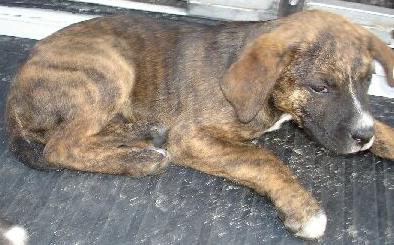

In [ ]:
dogs = list(data_dir.glob('dogs/*'))
PIL.Image.open(str(dogs[0]))

Make train **data** set

In [ ]:
batch_size = 32
img_height = 180
img_width = 180

https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image_dataset_from_directory

In [ ]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  image_size=(img_height, img_width),
  seed = 1,
  batch_size=batch_size)

Found 886 files belonging to 2 classes.
Using 709 files for training.


In [ ]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  image_size=(img_height, img_width),
   seed = 1,
  batch_size=batch_size)

Found 886 files belonging to 2 classes.
Using 177 files for validation.


In [ ]:
class_names = train_ds.class_names
print(class_names)

['cats', 'dogs']


Plot images

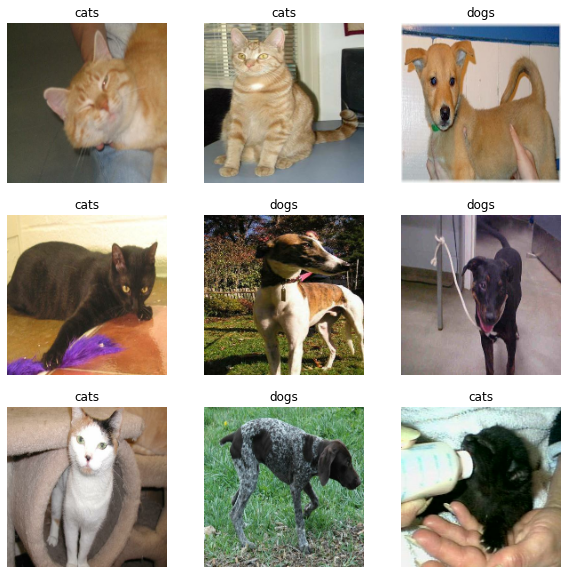

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [ ]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 180, 180, 3)
(32,)


In [ ]:
data_augmentation = keras.Sequential(
  [
    layers.experimental.preprocessing.RandomFlip("horizontal", input_shape=(img_height,  img_width, 3)),
    layers.experimental.preprocessing.RandomRotation(0.1),
    layers.experimental.preprocessing.RandomZoom(0.1),
  ]
)

Create Model

https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv2D

In [ ]:
num_classes = 2

model = Sequential([
  data_augmentation,
  layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.BatchNormalization(),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.BatchNormalization(),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.BatchNormalization(),
  layers.MaxPooling2D(),
  
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dropout(0.5),
  layers.Dense(num_classes)
])

In [ ]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 90, 90, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 45, 45, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 45, 45, 64)        1

In [ ]:
#callback 설정
import datetime
# 1. tensorboard
log_dir="logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

# 2. checkpoint
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath="./checkpoint",save_weights_only=True,monitor='val_accuracy',mode='max', save_best_only=True)

# 3. early stop
earlystop_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)


Training

In [ ]:
epochs=10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs,
  callbacks=[tensorboard_callback, checkpoint_callback,earlystop_callback ]
)

Epoch 1/10
23/23 [==============================] - 3s 125ms/step - loss: 0.0821 - accuracy: 0.9746 - val_loss: 1.2076 - val_accuracy: 0.6441
Epoch 2/10
23/23 [==============================] - 3s 127ms/step - loss: 0.0464 - accuracy: 0.9887 - val_loss: 1.6260 - val_accuracy: 0.6836
Epoch 3/10
23/23 [==============================] - 3s 119ms/step - loss: 0.0376 - accuracy: 0.9929 - val_loss: 1.6296 - val_accuracy: 0.6384
Epoch 4/10
23/23 [==============================] - 3s 130ms/step - loss: 0.0191 - accuracy: 1.0000 - val_loss: 1.8845 - val_accuracy: 0.6441


In [ ]:
%load_ext tensorboard
%tensorboard --logdir logs/fit

Train Results

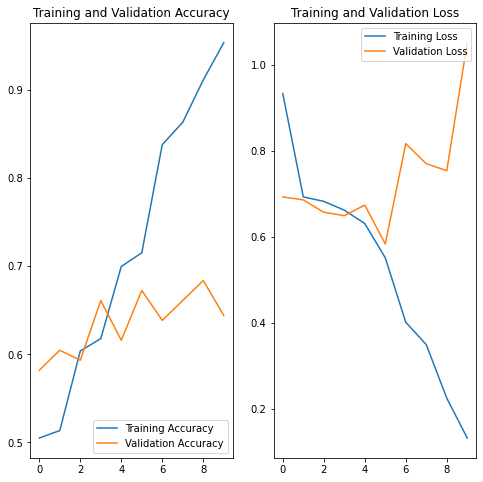

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
num_classes = 2

model2 = Sequential([
  layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])
model2.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
model2.load_weights('checkpoint')

In [ ]:
test_score = model2.evaluate(val_ds)

6/6 [==============================] - 1s 20ms/step - loss: 1.6260 - accuracy: 0.6836
